### Installation

In [1]:
# !pip install torch torchvision torchaudio
# !pip install nltk tqdm
# !pip install datasets
# !pip install torchtext

## Load and Explore the SNLI Dataset

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
import re
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download("punkt")


/scratch/rpt5409/anaconda3/envs/nlp1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load the dataset
dataset = load_dataset("snli")

# Convert to Pandas DataFrame for exploration
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

# Show sample data
df_train.head()


,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


In [4]:
df_train.tail()

,premise,hypothesis,label
550147,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2
550148,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1
550149,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1
550150,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2
550151,A man is surfing in a bodysuit in beautiful bl...,On the beautiful blue water there is a man in ...,0


In [5]:
# prompt: df_train : 0th index print; each separate .... df_train.iloc[0]["premise"]
if len(df_train) > 5:
  for i in range(5):
      print("premise:", end="")
      print(df_train.iloc[i]["premise"])
      print("hypothesis:", end="")
      print(df_train.iloc[i]["hypothesis"])
      print("label:", end="")
      print(df_train.iloc[i]["label"])
      print("===============================")


premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is training his horse for a competition.
label:1
premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is at a diner, ordering an omelette.
label:2
premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is outdoors, on a horse.
label:0
premise:Children smiling and waving at camera
hypothesis:They are smiling at their parents
label:1
premise:Children smiling and waving at camera
hypothesis:There are children present
label:0


0: "Entailment", 1: "Contradiction", 2: "Neutral"

# Check Data Distribution
What We Check
Label distribution: Are classes balanced?

Text length: Helps decide padding length.

### If we keep, unlabeled data then what is the distribution

/tmp/ipykernel_3892756/1155726302.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")


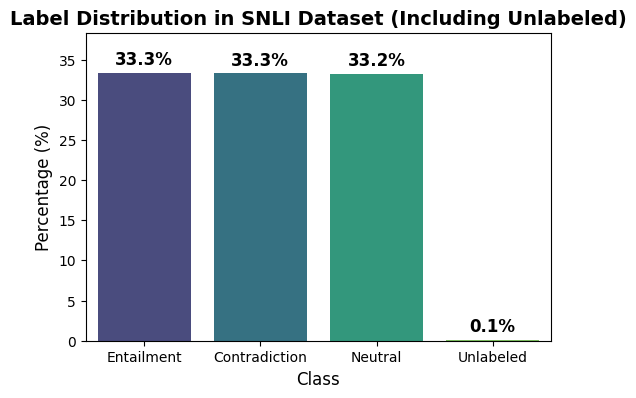

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

# Load SNLI dataset
dataset = load_dataset("snli")
df_train = pd.DataFrame(dataset["train"])

# Assuming df_train is already loaded
# Define label mapping (including -1 as "Unlabeled")
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction", -1: "Unlabeled"}
df_train["label_text"] = df_train["label"].map(label_names)

# Compute label distribution
label_counts = df_train["label_text"].value_counts(normalize=True) * 100  # Convert to percentages

# Create bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")

# Fix text positioning and font size
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight="bold")

# Final formatting
plt.title("Label Distribution in SNLI Dataset (Including Unlabeled)", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, max(label_counts.values) + 5)  # Add padding for better readability
plt.show()


In [7]:

print(df_train["label"].unique())


[ 1  2  0 -1]


## Removing unlabeled data

In [8]:
# Remove invalid labels (-1)
df_train = df_train[df_train["label"] != -1]

In [9]:
# Define label mapping
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
df_train["label_text"] = df_train["label"].map(label_names)

# Compute sentence lengths
nltk.download("punkt_tab")
df_train["premise_length"] = df_train["premise"].apply(lambda x: len(word_tokenize(x)))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x: len(word_tokenize(x)))



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


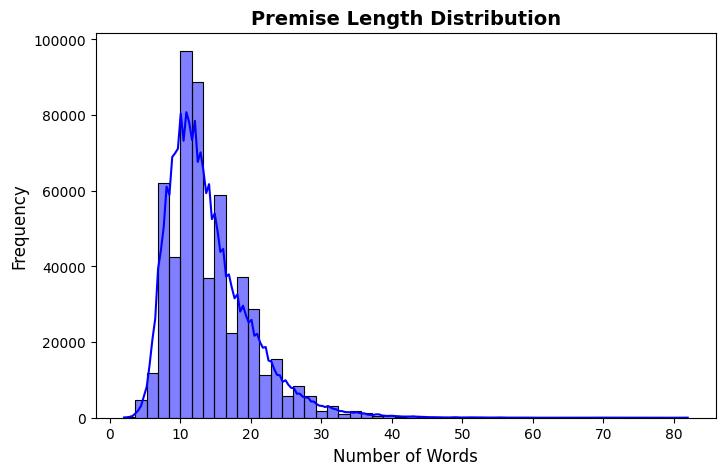

In [10]:
# Plot 1: Premise Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_train["premise_length"], bins=50, kde=True, color="blue")
plt.title("Premise Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()



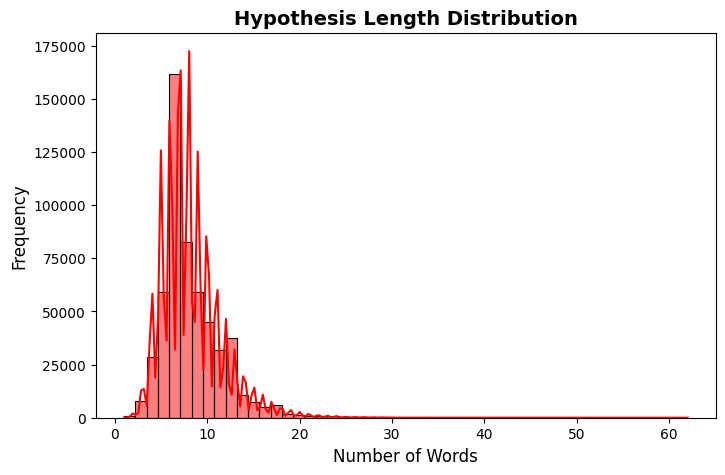

In [11]:
# Plot 2: Hypothesis Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_train["hypothesis_length"], bins=50, kde=True, color="red")
plt.title("Hypothesis Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()



/tmp/ipykernel_3892756/2033641802.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")


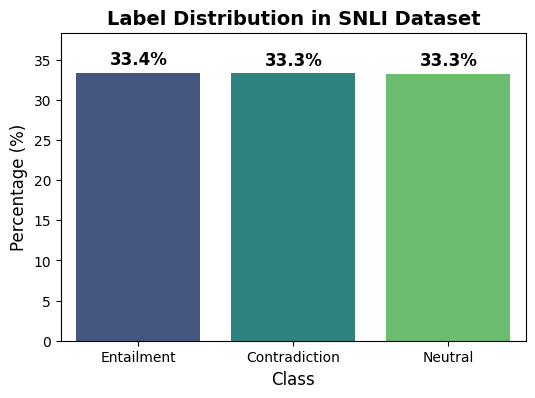

In [12]:
# Plot 3: Label Distribution (Percentage Bar Chart)
label_counts = df_train["label_text"].value_counts(normalize=True) * 100  # Convert to percentages
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")

# Fix text positioning and font size
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight="bold")

# Final formatting
plt.title("Label Distribution in SNLI Dataset", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, max(label_counts.values) + 5)  # Add padding for better readability
plt.show()

[nltk_data] Downloading package punkt to /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


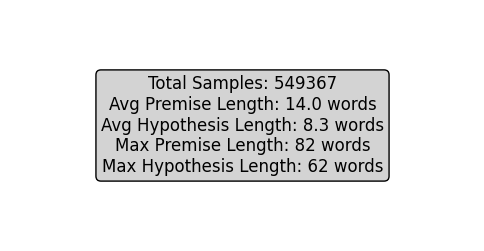

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

# Load SNLI dataset
dataset = load_dataset("snli")
df_train = pd.DataFrame(dataset["train"])

# Remove invalid labels (-1)
df_train = df_train[df_train["label"] != -1]

# Compute sentence lengths
nltk.download("punkt")
df_train["premise_length"] = df_train["premise"].apply(lambda x: len(word_tokenize(x)))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x: len(word_tokenize(x)))

# Generate statistics
total_samples = len(df_train)
avg_premise_len = df_train["premise_length"].mean()
avg_hypothesis_len = df_train["hypothesis_length"].mean()
max_premise_len = df_train["premise_length"].max()
max_hypothesis_len = df_train["hypothesis_length"].max()

# Create a blank plot for text display
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")  # Hide axes

# Dataset summary text
text_info = (
    f"Total Samples: {total_samples}\n"
    f"Avg Premise Length: {avg_premise_len:.1f} words\n"
    f"Avg Hypothesis Length: {avg_hypothesis_len:.1f} words\n"
    f"Max Premise Length: {max_premise_len} words\n"
    f"Max Hypothesis Length: {max_hypothesis_len} words"
)

# Add text inside the plot with background color
ax.text(0.5, 0.5, text_info, fontsize=12, verticalalignment="center",
        horizontalalignment="center", bbox=dict(boxstyle="round", facecolor="lightgrey"))

# Show the plot
plt.show()


In [14]:
print(text_info)

Total Samples: 549367
Avg Premise Length: 14.0 words
Avg Hypothesis Length: 8.3 words
Max Premise Length: 82 words
Max Hypothesis Length: 62 words


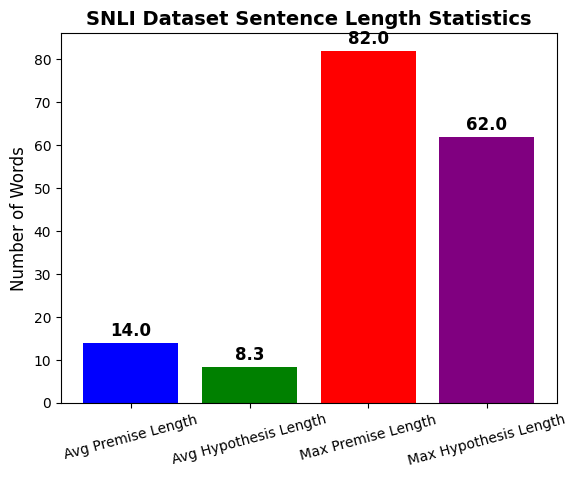

In [15]:
# Data for bar chart (excluding "Total Samples")
labels = ["Avg Premise Length", "Avg Hypothesis Length", "Max Premise Length", "Max Hypothesis Length"]

avg_premise_len = df_train["premise_length"].mean()
avg_hypothesis_len = df_train["hypothesis_length"].mean()
max_premise_len = df_train["premise_length"].max()
max_hypothesis_len = df_train["hypothesis_length"].max()

values = [avg_premise_len, avg_hypothesis_len, max_premise_len, max_hypothesis_len]
# Create bar chart
# plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["blue", "green", "red", "purple"])

# Add values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + max(values) * 0.02, f"{v:.1f}", ha='center', fontsize=12, fontweight="bold")

# Formatting
plt.title("SNLI Dataset Sentence Length Statistics", fontsize=14, fontweight="bold")
plt.ylabel("Number of Words", fontsize=12)
plt.xticks(rotation=15)  # Rotate labels for readability

# Show plot
plt.show()

In [16]:
len(df_train)

549367

In [17]:
len(df_test)

10000

In [18]:
len(df_val)

10000

### Step 3: Preprocess

In [19]:
import re
import nltk
from nltk.tokenize import word_tokenize



# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower().strip()  # Lowercasing and removing unnecessary spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return word_tokenize(text)  # Tokenize words

# Function to preprocess SNLI dataset
def preprocess_snli_data(df):
    pairs, labels = [], []

    # Define the correct label mapping
    label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}  # Fixed mapping

    for i, row in df.iterrows():
        if row["label"] != -1:  # Removing invalid labels (-1)
            premise = preprocess_text(row["premise"])
            hypothesis = preprocess_text(row["hypothesis"])
            pairs.append((premise, hypothesis))
            labels.append(row["label"])

    return pairs, labels


In [20]:

# Apply preprocessing to train, validation, and test sets
df_train = df_train[df_train["label"] != -1]  # Remove invalid labels
df_val = df_val[df_val["label"] != -1]
df_test = df_test[df_test["label"] != -1]



In [21]:
len(df_train)

549367

In [22]:
len(df_val)

9842

In [23]:
len(df_test)

9824

In [24]:
train_pairs, train_labels = preprocess_snli_data(df_train)
val_pairs, val_labels = preprocess_snli_data(df_val)
test_pairs, test_labels = preprocess_snli_data(df_test)




In [25]:
# Print sample to verify preprocessing
print("Sample Preprocessed Data:")
print("Premise:", train_pairs[0][0])
print("Hypothesis:", train_pairs[0][1])
print("Label:", train_labels[0])

Sample Preprocessed Data:
Premise: ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane']
Hypothesis: ['a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition']
Label: 1


In [26]:
len(train_pairs)

549367

### Step 4: Word Embeddings (GloVe)

Step 1: Download GloVe Embeddings

In [27]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip


 Step 2: Load GloVe into Python

Changing to embedding_dim = 300

In [28]:
import numpy as np

# Path to GloVe embeddings (change dim=50 if using another size)
glove_path = "glove.6B.50d.txt"
embedding_dim = 50

# Load GloVe embeddings into a dictionary
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]  # First value is the word
            vector = np.array(values[1:], dtype=np.float32)  # The rest are the vector values
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings(glove_path)
print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


###  4.2 Build Vocabulary

In [29]:
# Special tokens
word_to_index = {"<PAD>": 0, "<UNK>": 1}  # PAD for padding, UNK for unknown words
index_to_word = ["<PAD>", "<UNK>"]

# Populate vocabulary from training data
for premise, hypothesis in train_pairs:
    for word in premise + hypothesis:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)
            index_to_word.append(word)

# Vocabulary size
vocab_size = len(word_to_index)
print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 35937


### Step 4.3: Create the Embedding Matrix

In [30]:
import torch

# Initialize embedding matrix
vocab_size = len(word_to_index)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Assign GloVe embeddings, use random for missing words
for word, idx in word_to_index.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random for unknown words

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

print("Final Embedding Matrix Shape:", embedding_matrix.shape)


Final Embedding Matrix Shape: torch.Size([35937, 50])


### Step 5: Convert data into tensor format

Step 5.1: Encode Sentences as Word Indexes

In [31]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

# Define max sequence length based on data analysis (Step 2)
MAX_LENGTH = 500  # Most sentences are within 500 words

# Function to encode sentences into word indices
def encode_sentence(sentence, max_len=MAX_LENGTH):
    encoded = [word_to_index.get(word, 1) for word in sentence]  # 1 is "<UNK>"
    return torch.tensor(encoded[:max_len])  # Truncate if longer than max_len


In [32]:

# Convert dataset into tensor format
def encode_data(pairs, labels, max_len=MAX_LENGTH):
    premises = [encode_sentence(p, max_len) for p, h in pairs]
    hypotheses = [encode_sentence(h, max_len) for p, h in pairs]
    labels = torch.tensor(labels).unsqueeze(1)  # Fix: Ensure labels have correct shape

    # Pad sequences to make them the same length
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=0)
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=0)

    return premises_padded, hypotheses_padded, labels



# Encode train, validation, and test sets
train_prem, train_hyp, train_labels = encode_data(train_pairs, train_labels)
val_prem, val_hyp, val_labels = encode_data(val_pairs, val_labels)
test_prem, test_hyp, test_labels = encode_data(test_pairs, test_labels)

# Print shape of data
print("Train Premises Shape:", train_prem.shape)
print("Train Hypotheses Shape:", train_hyp.shape)
print("Train Labels Shape:", train_labels.shape)

Train Premises Shape: torch.Size([549367, 78])
Train Hypotheses Shape: torch.Size([549367, 56])
Train Labels Shape: torch.Size([549367, 1])


Step 5.2: Create DataLoader for Efficient Batching

In [33]:
# Define batch size
BATCH_SIZE = 64

# Create TensorDataset and DataLoader
train_data = TensorDataset(train_prem, train_hyp, train_labels)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(val_prem, val_hyp, val_labels)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_prem, test_hyp, test_labels)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print("DataLoaders created successfully!")


DataLoaders created successfully!


### Step 6: Build & Train the BiLSTM Model

 Step 6.1: Define the BiLSTM Model

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F




 Step 6.2: Initialize Model, Loss, and Optimizer

In [35]:
# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### Step 6.3: Train the Model

In [36]:
from tqdm import tqdm

### Stacked BiLSTM 

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackedBiLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        embedding_matrix=None,
        use_pretrained=True,
        freeze_embeddings=False,
        num_layers=2,
        dropout=0.3
    ):
        super(StackedBiLSTM, self).__init__()
        
        # Embedding layer
        if use_pretrained and embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, 
                freeze=freeze_embeddings  # fine-tune if False
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Stacked BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  # dropout only applies between LSTM layers
        )
        
        # Simple linear attention
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Final linear (concatenate premise & hypothesis embeddings => *4)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, premise, hypothesis):
        # Embedding
        prem_embed = self.embedding(premise)    # [batch, prem_len, emb_dim]
        hyp_embed  = self.embedding(hypothesis) # [batch, hyp_len,  emb_dim]
        
        # BiLSTM
        prem_out, _ = self.lstm(prem_embed)     # [batch, prem_len, hidden_dim*2]
        hyp_out,  _ = self.lstm(hyp_embed)      # [batch, hyp_len,  hidden_dim*2]
        
        # Attention weights
        prem_weights = torch.softmax(self.attention(prem_out), dim=1)  # [batch, prem_len, 1]
        hyp_weights  = torch.softmax(self.attention(hyp_out),  dim=1)  # [batch, hyp_len,  1]
        
        # Weighted sum
        prem_rep = torch.sum(prem_out * prem_weights, dim=1)  # [batch, hidden_dim*2]
        hyp_rep  = torch.sum(hyp_out  * hyp_weights,  dim=1)  # [batch, hidden_dim*2]
        
        # Concatenate & classification
        combined = torch.cat((prem_rep, hyp_rep), dim=1)      # [batch, hidden_dim*4]
        out = self.fc(self.dropout(self.relu(combined)))      # [batch, output_dim]
        
        return out


In [38]:
def evaluate(model, data_loader, device="cpu"):
    """Compute accuracy on a given dataset."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for premise, hypothesis, labels in data_loader:
            premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)
            outputs = model(premise, hypothesis)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels.squeeze()).sum().item()
            total += labels.size(0)
    return correct / total


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, device="cpu", lr=1e-4, num_epochs=10):
    """
    Trains `model` on `train_loader`, evaluates on `val_loader`.
    Returns logs of loss/accuracy for each epoch (train+val).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = [], []
    train_accs, val_accs     = [], []
    
    for epoch in range(num_epochs):
        # ----------------- TRAINING -----------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for premise, hypothesis, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            premise, hypothesis, labels = (
                premise.to(device),
                hypothesis.to(device),
                labels.to(device)
            )
            
            optimizer.zero_grad()
            outputs = model(premise, hypothesis)
            
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels.squeeze()).sum().item()
            total   += labels.size(0)
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        
        # ----------------- VALIDATION -----------------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total   = 0
        with torch.no_grad():
            for premise, hypothesis, labels in val_loader:
                premise, hypothesis, labels = (
                    premise.to(device),
                    hypothesis.to(device),
                    labels.to(device)
                )
                outputs = model(premise, hypothesis)
                
                val_loss = criterion(outputs, labels.squeeze())
                val_running_loss += val_loss.item()
                
                val_preds = torch.argmax(outputs, dim=1)
                val_correct += (val_preds == labels.squeeze()).sum().item()
                val_total   += labels.size(0)
        
        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        
        # Store logs
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    logs = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    }
    return logs


In [ ]:
hidden_dim = 512      # can be 512, 768, etc. 
embedding_dim = 50    # e.g., GloVe 300-d
num_layers = 2
dropout = 0.3

model_finetune = StackedBiLSTM(
    vocab_size=len(word_to_index),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=3,                   # SNLI has 3 classes
    embedding_matrix=embedding_matrix,  # GloVe embedding matrix
    use_pretrained=True,
    freeze_embeddings=False,        # fine-tune embeddings
    num_layers=num_layers,
    dropout=dropout
).to(device)


In [41]:
logs_finetune = train_and_evaluate(
    model=model_finetune,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    lr=1e-4,          # learning rate
    num_epochs=10
)


Epoch 1/10: 100%|██████████| 8584/8584 [06:02<00:00, 23.65it/s]


[Epoch 1/10] Train Loss: 0.8619, Train Acc: 0.6029, Val Loss: 0.7819, Val Acc: 0.6591


Epoch 2/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.52it/s]


[Epoch 2/10] Train Loss: 0.7763, Train Acc: 0.6577, Val Loss: 0.7511, Val Acc: 0.6753


Epoch 3/10: 100%|██████████| 8584/8584 [06:04<00:00, 23.54it/s]


[Epoch 3/10] Train Loss: 0.7469, Train Acc: 0.6750, Val Loss: 0.7364, Val Acc: 0.6818


Epoch 4/10: 100%|██████████| 8584/8584 [06:04<00:00, 23.52it/s]


[Epoch 4/10] Train Loss: 0.7277, Train Acc: 0.6863, Val Loss: 0.7218, Val Acc: 0.6904


Epoch 5/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.52it/s]


[Epoch 5/10] Train Loss: 0.7126, Train Acc: 0.6950, Val Loss: 0.7161, Val Acc: 0.6943


Epoch 6/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.49it/s]


[Epoch 6/10] Train Loss: 0.6992, Train Acc: 0.7023, Val Loss: 0.7155, Val Acc: 0.6932


Epoch 7/10: 100%|██████████| 8584/8584 [06:04<00:00, 23.52it/s]


[Epoch 7/10] Train Loss: 0.6854, Train Acc: 0.7096, Val Loss: 0.7157, Val Acc: 0.6985


Epoch 8/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.49it/s]


[Epoch 8/10] Train Loss: 0.6712, Train Acc: 0.7167, Val Loss: 0.7088, Val Acc: 0.6933


Epoch 9/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.50it/s]


[Epoch 9/10] Train Loss: 0.6553, Train Acc: 0.7248, Val Loss: 0.7091, Val Acc: 0.6991


Epoch 10/10: 100%|██████████| 8584/8584 [06:05<00:00, 23.49it/s]


[Epoch 10/10] Train Loss: 0.6361, Train Acc: 0.7340, Val Loss: 0.7189, Val Acc: 0.7026


In [42]:
test_acc = evaluate(model_finetune, test_loader, device=device)
print(f"Test Accuracy (Fine-tuned Model): {test_acc:.4f}")


Test Accuracy (Fine-tuned Model): 0.6950


Saved training logs to finetune_logs.csv


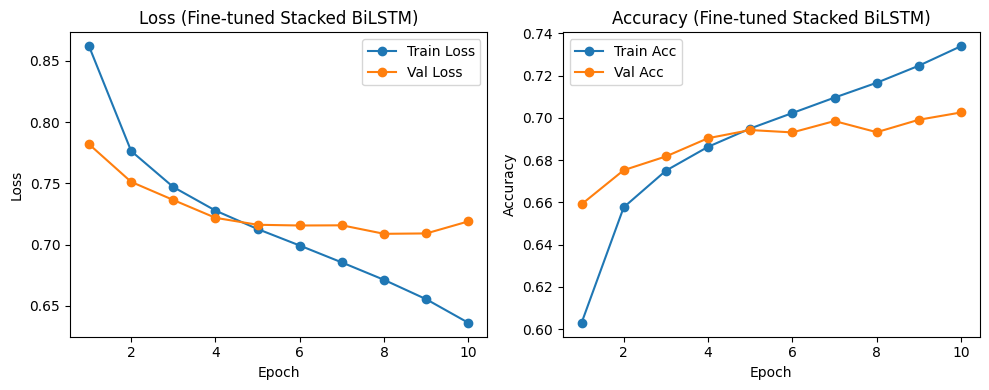

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

epochs = range(1, len(logs_finetune["train_loss"]) + 1)

df_finetune = pd.DataFrame({
    "epoch": epochs,
    "train_loss": logs_finetune["train_loss"],
    "val_loss":   logs_finetune["val_loss"],
    "train_acc":  logs_finetune["train_acc"],
    "val_acc":    logs_finetune["val_acc"]
})

df_finetune.to_csv("finetune_logs.csv", index=False)
print("Saved training logs to finetune_logs.csv")

# Plot
plt.figure(figsize=(10,4))

# --- Subplot 1: Loss ---
plt.subplot(1,2,1)
plt.plot(df_finetune["epoch"], df_finetune["train_loss"], label="Train Loss", marker='o')
plt.plot(df_finetune["epoch"], df_finetune["val_loss"],   label="Val Loss",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Fine-tuned Stacked BiLSTM)")
plt.legend()

# --- Subplot 2: Accuracy ---
plt.subplot(1,2,2)
plt.plot(df_finetune["epoch"], df_finetune["train_acc"], label="Train Acc", marker='o')
plt.plot(df_finetune["epoch"], df_finetune["val_acc"],   label="Val Acc",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (Fine-tuned Stacked BiLSTM)")
plt.legend()

plt.tight_layout()
plt.show()
